In [2]:
import pandas as pd, numpy as np, scipy.stats as ss
def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

def crypto_kruskal(site,pheno):
    refxpheno = np.array(pheno,dtype=float)[np.array(site)==0]
    altxpheno = np.array(pheno,dtype=float)[np.array(site)==1]
    return -np.log10(ss.kruskal(refxpheno,altxpheno)[1])

from matplotlib import pyplot as plt
%matplotlib inline

# Data curation

In [3]:
## Load phentype data
data_path = './XL280x431_cross_amoeba_processed_10_23_2020.csv'
ph = pd.read_csv(data_path)
ph = ph[(ph.Strain!='KN99')]
ph.head()

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12
0,431alpha,1,2,10,p2_1,0.57912,4.58978
1,431alpha,1,1,11,p1_1,0.62484,6.98500
2,B307,1,3,10,p2_1,1.62306,12.00404
3,B308,1,2,10,p2_1,0.22352,4.71170
4,B310,1,5,10,p2_1,0.48006,4.46532


In [4]:
## Load genotype data
genotype_path = './CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(genotype_path)
gv.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [5]:
Strain_names = []
Dont_rep = []
for i,j in ph.iterrows():
    
    s = j.Strain
    
    if s in gv.columns:
        Strain_names.append(s)
    
    elif 'SS-'+s in gv.columns:
        Strain_names.append('SS-'+s)
            
    elif s == '431alpha':
        Strain_names.append('SS-A837')
    elif s == 'KN99':
        Strain_names.append('KN99')
    else:
        Dont_rep.append('SS-'+s)
        Strain_names.append(s)

print(len(Strain_names))
print(Strain_names[:10])

119
['SS-A837', 'SS-A837', 'SS-B307', 'B308', 'SS-B310', 'SS-B311', 'SS-B312', 'SS-B313', 'SS-B314', 'SS-B315']


In [6]:
ph['Sample'] = Strain_names

for i,j in ph.iterrows():
    if not j.Strain == j.Sample.split('SS-')[-1]:
        print(j.Strain)

431alpha
431alpha


In [7]:
ph.head()

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample
0,431alpha,1,2,10,p2_1,0.57912,4.58978,SS-A837
1,431alpha,1,1,11,p1_1,0.62484,6.98500,SS-A837
2,B307,1,3,10,p2_1,1.62306,12.00404,SS-B307
3,B308,1,2,10,p2_1,0.22352,4.71170,B308
4,B310,1,5,10,p2_1,0.48006,4.46532,SS-B310


In [8]:
pheno = ph[(ph.Sample.isin(gv.columns))][['Sample','Area.12']]
pheno.columns = ['Sample','Growth'] ## Rename column names
## Take mean phenotype per strain
mean_pheno = pheno.groupby('Sample').mean().sort_values('Growth')
mean_pheno.shape

(95, 1)

In [9]:
mean_pheno.tail()

,Growth
Sample,
SS-B580,NaN
SS-B586,NaN
SS-B906_cor,NaN
SS-B961,NaN
SS-C029_cor,NaN


In [10]:
mean_pheno.dropna(inplace=True)

In [11]:
mean_pheno.shape

(90, 1)

In [12]:
mean_pheno.reset_index(inplace=True)

# Phenotype visulization and exploration

In [13]:
from matplotlib import rc
xl280alpha_label = 'XL280'+r'$\alpha$'
xl280a_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

myylabel = 'Area of clearance\nby amoeba (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

In [14]:
parentals = ['SS-A837','XL280a','XL280alpha']
parental_labels = [_431_label,xl280a_label,xl280alpha_label]

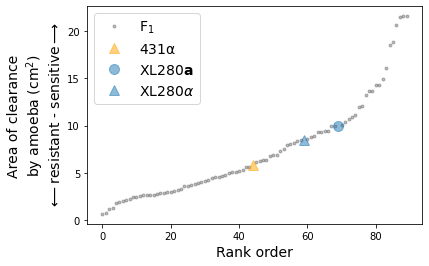

In [15]:
## Plot segregants
plt.plot(mean_pheno[~(mean_pheno.Sample.isin(parentals))].index,
         mean_pheno[~(mean_pheno.Sample.isin(parentals))].Growth.values,
         'k.',alpha=0.25,label='F$_{1}$');


for i,p in enumerate(parentals):
    
    plt.plot(mean_pheno[(mean_pheno.Sample == p )].index,
         mean_pheno[(mean_pheno.Sample == p)].Growth.values,
         'o' if i ==1 else '^',alpha=0.5,label=parental_labels[i],
             color='orange' if p =='SS-A837' else 'tab:blue',ms=10);
    
plt.xlabel('Rank order',fontsize=14);
plt.ylabel(myylabel,
           fontsize=14)
plt.legend(fontsize=14);
plt.savefig('../Desktop/XL280x431_amoeba_assay.png',
            dpi=150,bbox_inches='tight');

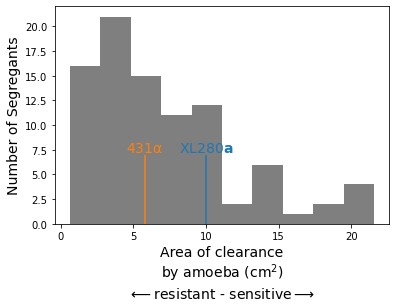

In [16]:
## Plot all
plt.hist(mean_pheno.Growth.values,
         color='k',alpha=0.5,label='$F_1$')
         
## Label x and y axis
plt.xlabel(myylabel,fontsize=14)
plt.ylabel('Number of Segregants',fontsize=14);

## Plot parents

_431_growth = mean_pheno[(mean_pheno.Sample=='SS-A837')].Growth
plt.vlines(_431_growth,
           0,7,color='tab:orange',label=parental_labels[0])

## annotate the parental strain name
plt.text(_431_growth,7,s=parental_labels[0],
         va='bottom',ha='center',fontsize=14,color='tab:orange')


## Plot parents
xl280a_growth = mean_pheno[(mean_pheno.Sample=='XL280a')].Growth
plt.vlines(xl280a_growth,
           0,7,color='tab:blue',label=parental_labels[1]);

## annotate the parental strain name
plt.text(xl280a_growth,7,s=parental_labels[1],
         va='bottom',ha='center',fontsize=14,color='tab:blue');

## Summon the legend
#plt.legend(fontsize=14);

In [17]:
ss.shapiro(mean_pheno.Growth.values)

ShapiroResult(statistic=0.890580415725708, pvalue=1.571833081470686e-06)

In [18]:
ss.normaltest(mean_pheno.Growth.values)

NormaltestResult(statistic=18.576442436788152, pvalue=9.250746459346702e-05)

# QTL Mapping

In [19]:
mapping_pop = mean_pheno.Sample.tolist()
len(mapping_pop)

90

In [20]:
## Gather unique loci
loci = gv[mapping_pop].drop_duplicates().copy()
loci.head()

,SS-B570,SS-B874,SS-B929,SS-C272,SS-B374,SS-B407,SS-B874_cor,SS-B368,SS-B960_cor,SS-B997,...,SS-B599,SS-B350,SS-B569,SS-B901_cor,SS-B600,SS-C036,SS-B369,SS-B317,SS-B358,SS-C039
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
232,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
249,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
252,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
254,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [21]:
## Cunduct QTL mapping

loci['Pval'] = loci[mapping_pop].apply(association_logPval,args=[mean_pheno.Growth.values],axis=1)
#loci['Pval'] = loci[mapping_pop].apply(crypto_kruskal,args=[mean_pheno.Growth.values],axis=1)

In [22]:
qtldf = gv.merge(loci)

## Plot QTL

In [23]:
## Make a list of the unique chromosomes
chrlist = sorted(qtldf.Chrom.unique())
assert len(chrlist)==14
print(chrlist[:4])

['Chr01', 'Chr02', 'Chr03', 'Chr04']


In [24]:
## Estimate and gather maximum chromosome length
chrommap = qtldf.groupby('Chrom')['Pos'].max().reset_index()

chrommap['Cumlen'] = [0] + chrommap.Pos.cumsum().tolist()[:-1]
chrommap['Midpts'] = (chrommap.Pos.values/2) + chrommap.Cumlen.values

chrommap.head()

,Chrom,Pos,Cumlen,Midpts
0,Chr01,2295469,0,1147734.5
1,Chr02,1623022,2295469,3106980.0
2,Chr03,2100376,3918491,4968679.0
3,Chr04,1777939,6018867,6907836.5
4,Chr05,1451825,7796806,8522718.5


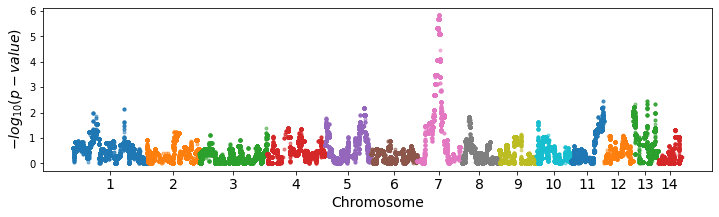

In [25]:
fig,ax = plt.subplots(1,1,figsize=(12,3))

for i,j in chrommap.iterrows():
    
    
    temp = qtldf[(qtldf.Chrom == j.Chrom)]
    
    plt.plot( temp.Pos.values+j.Cumlen, temp.Pval.values,'.',alpha=0.5);

plt.xticks(chrommap.Midpts.values, np.arange(1,15),fontsize=14)
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome',fontsize=14);

plt.savefig('../Desktop/XL280x431_amoeba_assay_QTL.png',
           dpi=150,bbox_inches='tight');
#ax1 = fig.add_axes([0.125,-0.75,.3,.1])

In [26]:
qtlix = qtldf.Pval.idxmax()
qtlchorm = qtldf.loc[qtlix,'Chrom']
qtlchorm

'Chr07'

In [27]:
temp = qtldf[(qtldf.Chrom == qtlchorm)]

In [28]:
mean_pheno['QTL'] = gv.loc[qtlix,mapping_pop].values

In [29]:
mean_pheno.head()

,Sample,Growth,QTL
0,SS-B570,0.63754,1
1,SS-B874,0.78486,0
2,SS-B929,1.10744,1
3,SS-C272,1.25984,1
4,SS-B374,1.83388,1


In [30]:
import statsmodels.formula.api as smf, seaborn as sns

In [31]:
res = smf.ols('Growth~QTL',data=mean_pheno).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     26.71
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           1.46e-06
Time:                        09:10:40   Log-Likelihood:                -262.12
No. Observations:                  90   AIC:                             528.2
Df Residuals:                      88   BIC:                             533.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4835      0.637     14.893      0.000       8.218      10.749
QTL[T.1.0]    -4.9368      0.955     -5.169      0.000      -6.835      -3.039
==============================================================================
Omnibus:                       10.889   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.019
Skew:                           0.787   Prob(JB):                      0.00405
Kurtosis:                       3.677   Cond. No.                         2.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
-np.log10(res.pvalues[1])

5.835565252542225

In [33]:
r2 = np.round(res.rsquared,2)
r2

0.23

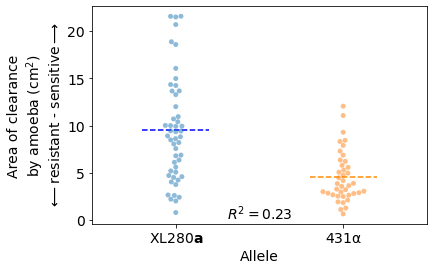

In [34]:
#just_segs = mean_pheno[~(mean_pheno.Sample.isin(parental_labels[:2]))]
sns.swarmplot(x='QTL',y='Growth',data=mean_pheno,alpha=0.5);

for gt in [0,1]:
    plt.hlines(mean_pheno[(mean_pheno.QTL==gt)].Growth.mean(),
           -0.2+gt,0.2+gt,linestyle='--',
               color='blue' if gt == 0 else 'darkorange')

plt.text(0.5,0.8,'$R^2 = %s$'%r2,color='k',
         va='center',ha='center',fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(myylabel,fontsize=14)
plt.xlabel('Allele',fontsize=14)
plt.xticks([0,1],parental_labels[:2][::-1],fontsize=14)
plt.savefig('../Desktop/XL280x431_amoeba_assay_genotype_by_phenotype.png',
           dpi=100,bbox_inches='tight');

In [35]:
gene_changes = pd.read_csv('/home/croth/Downloads/XL280_431_gene_analysis.csv.gz')
gff = pd.read_csv('/home/croth/Downloads/xl280genome.gff3.csv.gz',index_col=0)

## Boot strap phenotype and genotype on chromosome 7

In [36]:
bsp = []
perms = 200
mean_pheno.index = mean_pheno.Sample
chrom = gv[(gv.Chrom==qtlchorm)
          ][mapping_pop+['Pos']].copy().reset_index(drop=True)

#for i in range(perms):
#    
#    bsegs = np.random.choice(mapping_pop,len(mapping_pop))
#    bpheno = mean_pheno.loc[bsegs,'Growth'].values
    
#    bloci = chrom[bsegs].drop_duplicates()
    
#    bloci['Pval'] = bloci.apply(association_logPval,args=[bpheno],axis=1)
        
#    bres = chrom.merge(bloci.T.drop_duplicates().T)
#    bres.sort_values('Pval',inplace=True)
    
#    bpos = bres[(bres.Pval==bres.Pval.max())].Pos.median()
#    bsp.append((bpos,bres.Pval.max()))
    
#bdf = pd.DataFrame(bsp,columns=['Pos','Pval'])

#qtl_ci = (np.percentile(bdf.Pos,5), np.percentile(bdf.Pos,95))
#qtl_ci

In [37]:
changes = gene_changes.merge(gff[(gff.type=='gene')][
    ['gene','start','end','description','strand']]).sort_values('start').copy()

qtl_ci = (changes[(changes.gene=='CNG02235')].start.min(),changes[(changes.gene=='CNG02480')].end.max())

changes['description'] = [d.split('%2C')[0] for d in changes.description]

bad_description = ['hypothetical protein',
                   'conserved hypothetical protein',
                   'expressed protein']

hypoix = ~(changes.description.isin(bad_description))

qtl_genes_all = changes[(changes.start>=np.min(qtl_ci)) & 
                        (changes.end<=np.max(qtl_ci)) & 
                        (changes.chrom==qtlchorm)]
qtl_genes_all.shape

(23, 10)

In [38]:
recombci = pd.DataFrame(chrom[(chrom.Pos.isin(np.arange(np.min(qtl_ci),np.max(qtl_ci)+1)))].diff(axis=0).abs().sum()[:-1],columns=['Crossovers'])

qtl_recombinants = recombci[(recombci.Crossovers>0)].index.tolist()

qtl_recombinants_gt = chrom[(chrom.Pos.isin(np.arange(np.min(qtl_ci),np.max(qtl_ci)+1)))][qtl_recombinants+['Pos']]

sorted_recombinants = mean_pheno.loc[qtl_recombinants].sort_values('Growth').Sample.tolist()
sorted_growth = mean_pheno.loc[qtl_recombinants].sort_values('Growth').Growth.values

In [39]:
centolocs = pd.read_csv('./XL280-centromere-locs.csv',index_col=0)
centolocs.columns = ['Left','Right']
centolocs

,Left,Right
Chr01,937505,998062
Chr02,855280,905374
Chr03,801551,911882
Chr04,217000,278992
Chr05,777789,854398
Chr06,864013,938913
Chr07,882637,911994
Chr08,706110,761065
Chr09,323968,388527
Chr10,802373,882178


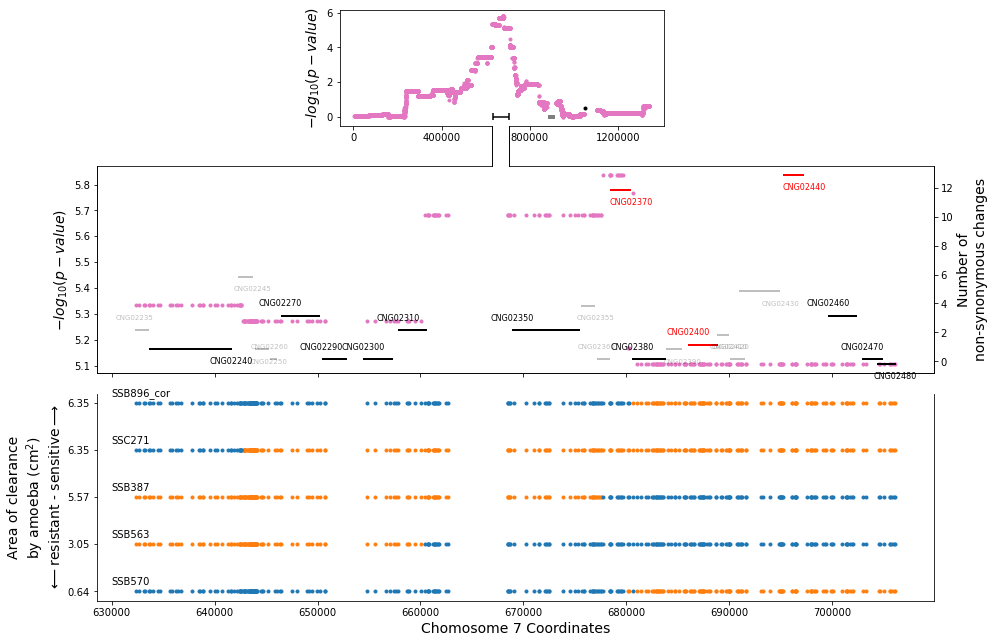

In [40]:
fig,ax = plt.subplots(2,1,figsize=(15,8),sharex=True)

ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax1)
for i,j in qtl_genes_all.iterrows():
    
    ## Stop gain or stop loss
    if j.nonsense>0:
        mycolor= 'r'
    else:
        mycolor='k'
    
    ## invariant
    if j.description in bad_description:
        myalpha = 0.25
        myfontsize= 7
    else:
        myalpha = 1
        myfontsize=8
    
    ## strand
    if j.strand == '-':
        ymod = -1
        xmod = j.end
        hamod = 'left'
        
    else:
        ymod = 1
        xmod = j.start
        hamod = 'right'
    
    plt.hlines(j.missense+(0.15*ymod),j.start,j.end,color=mycolor,alpha=myalpha,linewidth=2);
    plt.text(xmod,j.missense+ymod,s=j.gene,
             ha='center',va='center',color=mycolor,alpha=myalpha,
             fontsize=myfontsize)
    

plt.ylabel('Number of\nnon-synonymous changes',fontsize=14)
    
    
    
## Plot QTL    
qtlax =  fig.add_axes([0.35,.95,.3,.2])

plt.sca(qtlax)
plt.plot(temp.Pos.values,temp.Pval.values,'.',color='tab:pink');

l,p = plt.xticks()

plt.xticks(l[1:-1][::2],[int(p) for p in l[1:-1][::2]]);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);

plt.plot(np.mean([1047647,1048359]), 0.5,'k.')


plt.hlines(0,*qtl_ci,'k')
plt.vlines(qtl_ci,-0.2,0.2,color='k');

plt.hlines(0,np.min(centolocs.T[qtlchorm].values),
             np.max(centolocs.T[qtlchorm].values),
           color='k',alpha=0.5,linewidth=4);

ax1.spines['top'].set_visible(False)
#ax.spines['top'].set_visible(False)


boxs = [[0.491,.88,.00000003,.07],[0.507,.88,.0000003,.07],[0.4915,.85,0.015,0.11]]
for i,b in enumerate(boxs):
    axl = fig.add_axes(b)
    plt.sca(axl)
    plt.yticks([])
    plt.xticks([])
    if i > 1:
        [axl.spines[a].set_visible(False) for a in ['top','left','right','bottom']]
        
## Plot the QTL peak
plt.sca(ax[0])
peak = temp[(temp.Pos>=np.min(qtl_ci)) & (temp.Pos<=np.max(qtl_ci))]
plt.plot(peak.Pos,peak.Pval,'.',color='tab:pink')
plt.ylabel("$-log_{10}(p-value)$",fontsize=14)


plt.sca(ax[1])


plt.xlabel('Chomosome %s Coordinates'%int(qtlchorm[-2:]),fontsize=14);
for i,c in enumerate(sorted_recombinants):
    
    _431 = qtl_recombinants_gt[(qtl_recombinants_gt[c]==0)][[c,'Pos']]
    _xl280  = qtl_recombinants_gt[(qtl_recombinants_gt[c]==1)][[c,'Pos']]

    plt.plot(_431.Pos,i*np.ones(_431.Pos.shape),'.',color='tab:orange');
    plt.plot(_xl280.Pos,i*np.ones(_xl280.Pos.shape),'.',color='tab:blue');
    
    plt.text(630000,i+0.2,s=''.join(c.split('-')),
             va='center',ha='left',fontsize=10)
    
plt.yticks(np.arange(len(sorted_growth)),[str(g) for g in np.round(sorted_growth,2)]);
plt.ylabel(myylabel,fontsize=14)
plt.subplots_adjust(hspace=0.1)
ax[1].spines['top'].set_visible(False)



plt.savefig('../Desktop/XL280x431_amoeba_assay_chromosome_%s_QTL_ZOOM.pdf'%int(qtlchorm[-2:]),
            dpi=300,bbox_inches='tight')

In [52]:
qtl_genes_all

,chrom,gene,mod_three,length_check,nonsense,missense,start,end,description,strand
3166,Chr07,CNG02235,0,0,0,2,632254,633672,hypothetical protein,+
3208,Chr07,CNG02240,0,0,0,1,633632,641667,two-component-like sensor kinase,-
3099,Chr07,CNG02245,0,0,0,6,642267,643708,hypothetical protein,-
3235,Chr07,CNG02250,0,0,0,1,643957,645249,hypothetical protein,-
3043,Chr07,CNG02260,0,0,0,0,645383,646074,hypothetical protein,+
2979,Chr07,CNG02270,0,0,0,3,646416,650196,Metal-binding regulatory protein CUF1,+
3032,Chr07,CNG02290,0,0,0,0,650403,652824,pre-mRNA splicing factor,+
3220,Chr07,CNG02300,0,0,0,0,654465,657334,regulation of budding-related protein,+
3174,Chr07,CNG02310,0,0,0,2,657811,660608,chaperone,+
3205,Chr07,CNG02350,0,0,0,2,668869,675514,putative translational repressor,+


In [42]:
qtl_ci

(632254, 706135)

In [43]:
mean_pheno.loc[qtl_recombinants].sort_values('Growth')

,Sample,Growth,QTL
Sample,,,
SS-B570,SS-B570,0.63754,1
SS-B563,SS-B563,3.04546,1
SS-B387,SS-B387,5.57276,1
SS-C271,SS-C271,6.34746,0
SS-B896_cor,SS-B896_cor,6.35000,1


In [44]:
fine_mapped = pd.read_csv('./Ameoba_chromosome_7_QTL_Finemapped.csv',
                         index_col=0)
fine_segs = sorted(fine_mapped.columns.tolist()[5:])

fine_mapped.head()

,Chrom,Pos,Ref,Alt,Af,171,129,184
6938,Chr07,650280,C,G,0.455446,0,0,0
6939,Chr07,650740,T,A,0.455446,0,0,0
6940,Chr07,650771,G,A,0.455446,0,0,0
6942,Chr07,654831,C,T,0.455446,0,0,0
27554,Chr07,675005,C,T,0.455446,0,0,0


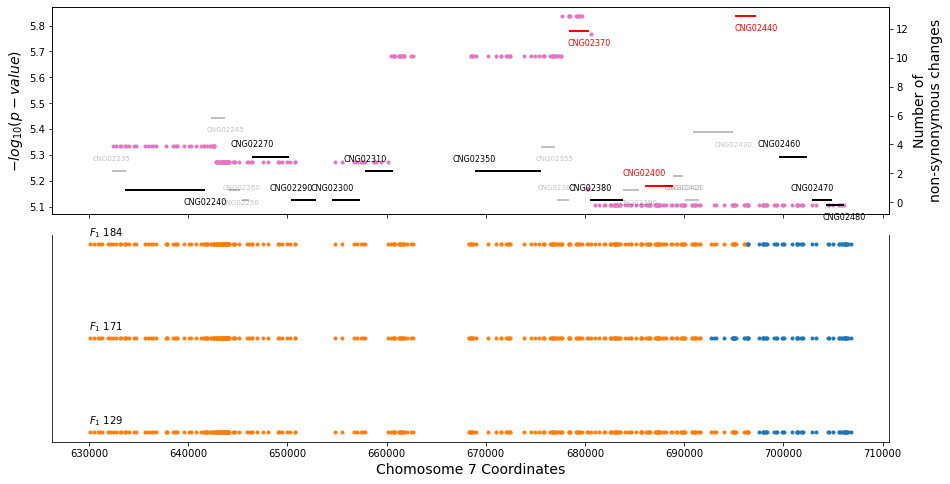

In [45]:
fig,ax = plt.subplots(2,1,figsize=(15,8),sharex=True)

ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax1)
for i,j in qtl_genes_all.iterrows():
    
    ## Stop gain or stop loss
    if j.nonsense>0:
        mycolor= 'r'
    else:
        mycolor='k'
    
    ## invariant
    if j.description in bad_description:
        myalpha = 0.25
        myfontsize= 7
    else:
        myalpha = 1
        myfontsize=8
    
    ## strand
    if j.strand == '-':
        ymod = -1
        xmod = j.end
        hamod = 'left'
        
    else:
        ymod = 1
        xmod = j.start
        hamod = 'right'
    
    plt.hlines(j.missense+(0.15*ymod),j.start,j.end,color=mycolor,alpha=myalpha,linewidth=2);
    plt.text(xmod,j.missense+ymod,s=j.gene,
             ha='center',va='center',color=mycolor,alpha=myalpha,
             fontsize=myfontsize)
    

plt.ylabel('Number of\nnon-synonymous changes',fontsize=14)
    
## Plot the QTL peak
plt.sca(ax[0])
peak = temp[(temp.Pos>=np.min(qtl_ci)) & (temp.Pos<=np.max(qtl_ci))]
plt.plot(peak.Pos,peak.Pval,'.',color='tab:pink')
plt.ylabel("$-log_{10}(p-value)$",fontsize=14)


plt.sca(ax[1])


plt.xlabel('Chomosome %s Coordinates'%int(qtlchorm[-2:]),fontsize=14);
for i,c in enumerate(fine_segs):
    
    _431 = fine_mapped[(fine_mapped[c]==0)][[c,'Pos']]
    _xl280  = fine_mapped[(fine_mapped[c]==1)][[c,'Pos']]

    plt.plot(_431.Pos,i*np.ones(_431.Pos.shape),'.',color='tab:orange');
    plt.plot(_xl280.Pos,i*np.ones(_xl280.Pos.shape),'.',color='tab:blue');
    
    plt.text(630000,i+0.12,s='$F_1$ %s'%c,
             va='center',ha='left',fontsize=10)
    
#plt.yticks(np.arange(len(sorted_growth)),[str(g) 
#                             for g in np.round(sorted_growth,2)]);
#plt.ylabel(myylabel,fontsize=14)
plt.subplots_adjust(hspace=0.1)
ax[1].spines['top'].set_visible(False)
plt.yticks([])

plt.savefig('../Desktop/Fine_mapped_chromosome_%s_QTL_ZOOM.pdf'%int(qtlchorm[-2:]),
            dpi=300,bbox_inches='tight')

# Initial Exploration

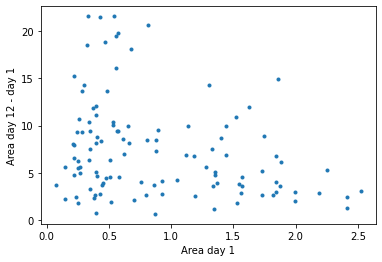

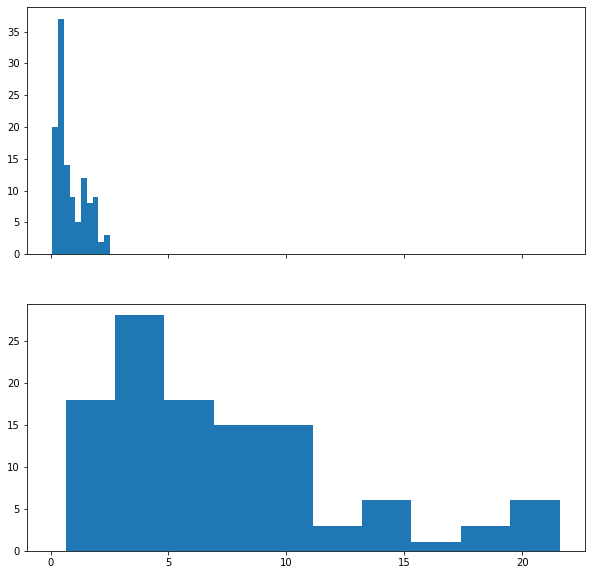

In [50]:
plt.plot(ph['Area.1'].values,ph['Area.12'].values,'.');
plt.xlabel('Area day 1');plt.ylabel('Area day 12 - day 1');
fig,ax = plt.subplots(2,1,figsize=(10,10),sharex=True)
plt.sca(ax[0])
plt.hist(ph['Area.1'].values);
plt.sca(ax[1])
plt.hist(ph['Area.12'].values);

In [53]:
len(Dont_rep)
print(Dont_rep)

['SS-B308', 'SS-B353', 'SS-B376', 'SS-B377', 'SS-B410', 'SS-B518', 'SS-B869', 'SS-B873', 'SS-B890', 'SS-B892', 'SS-B896', 'SS-B898', 'SS-B901', 'SS-B932', 'SS-B960', 'SS-C026', 'SS-C029', 'SS-C030', 'SS-C031', 'SS-C366']


In [54]:
open('./DONT_REPLICATE_XL280_431.csv','w').writelines('\n'.join(Dont_rep))

In [55]:
gv_samples = [c for c in gv.columns 
              if c[:3]=='SS-'] + ['XL280a','XL280alpha']
len(gv_samples)

104

In [56]:
missing_samples = [s for s in gv_samples if s not in Strain_names]
print(len(missing_samples))
print(missing_samples)

## SS-B621 failed cracked plate
## SSS-B587 contamonatied
## The remaning did not grow

9
['SS-B366', 'SS-B383', 'SS-B621', 'SS-B587', 'SS-B892_cor', 'SS-B553', 'SS-B952', 'SS-B396', 'SS-B598']


In [76]:
ph.loc[[i for i in ph.index.tolist() if i not in ph.dropna().index],]

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample
46,B580,1,1,11,p1_1,0.61468,NaN,SS-B580
49,B586,1,1,11,p1_1,0.41402,NaN,SS-B586
75,B896,1,4,10,p2_1,0.16764,NaN,B896
83,B906_cor,1,5,11,p1_1,0.35560,NaN,SS-B906_cor
94,B961,1,5,10,p2_1,0.78740,NaN,SS-B961
103,C029_cor,1,2,10,p2_1,0.47244,NaN,SS-C029_cor


In [68]:
ph[(ph.Strain.isin(['B961','B580','B586','B906_cor']))]

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample
46,B580,1,1,11,p1_1,0.61468,NaN,SS-B580
49,B586,1,1,11,p1_1,0.41402,NaN,SS-B586
83,B906_cor,1,5,11,p1_1,0.35560,NaN,SS-B906_cor
94,B961,1,5,10,p2_1,0.78740,NaN,SS-B961


In [62]:
'SS-B580' in gv_samples

True

In [61]:
'SS-B961' in gv_samples

True